In [16]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, Ridge, SGDRegressor, LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

import xgboost as xgb

## 1.Load data

In [2]:
df_channel = pd.read_csv('orders_channels.csv')
df_country = pd.read_csv('orders_country.csv')
df_tickets = pd.read_csv('orders_tickets.csv')

In [3]:
df_merged = pd.merge(df_channel, df_tickets, how='left', on=['id'])
df_merged = pd.merge(df_merged, df_country, how='left', on=['id'])

## 2. Exploratory Data Analysis (EDA) 

In [4]:
df_channel.head()

,id,date,channel_id
0,10173,2017-06-12,39.0
1,95062,2017-09-11,35.0
2,171081,2017-07-05,39.0
3,122867,2017-08-18,39.0
4,107186,2017-11-23,NaN


In [5]:
df_channel.shape

(2054059, 3)

In [6]:
df_channel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2054059 entries, 0 to 2054058
Data columns (total 3 columns):
id            int64
date          object
channel_id    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 47.0+ MB


In [7]:
df_channel['channel_id'].isnull().sum()

295625

In [8]:
df_channel['channel_id'].unique()

array([39., 35., nan, 28., 37., 40., 31., 49., 26., 29.,  2.,  1., 33.,
       17., 30., 25., 23., 38., 43., 36.,  5., 42., 41., 24.,  4., 27.,
       32., 47.,  8., 13.])

In [9]:
len(df_channel['channel_id'].unique())

30

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000ACD3D30>]],
      dtype=object)

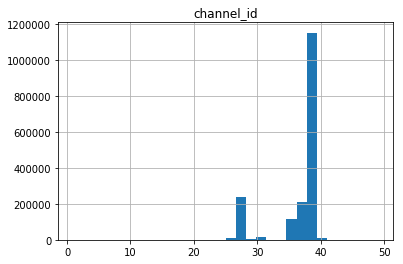

In [12]:
df_channel.hist(column='channel_id', bins=len(df_channel['channel_id'].unique()))

In [13]:
df_channel['date'] = pd.to_datetime(df_channel['date'])

In [18]:
df_country.head()

,id,country_1,country_2
0,10503,24.0,NaN
1,79360,24.0,0
2,81388,24.0,15
3,82828,24.0,9
4,38756,23.0,NaN


In [19]:
df_country.shape

(1917668, 3)

In [20]:
df_country.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1917668 entries, 0 to 1917667
Data columns (total 3 columns):
id           int64
country_1    float64
country_2    object
dtypes: float64(1), int64(1), object(1)
memory usage: 43.9+ MB


In [21]:
df_country['country_1'].isnull().sum()

17831

In [22]:
df_country['country_2'].isnull().sum()

748932

In [23]:
df_country['country_1'].unique()

array([24., 23., 19., 11., 12.,  9.,  4., 29., 14.,  5., 20., 26., 27.,
        8., 21.,  7., 32., nan, 28., 17., 15., 31., 16., 22.])

In [24]:
df_country['country_2'].unique()

array([nan, '0', '15', '9', '13', '4', '2', '6', '17', '8', '14', '20',
       '16', '12', '3', '19', '18', '11', 'xx', '1', '7'], dtype=object)

In [46]:
df_tickets.head()

,id,n_tickets,type
0,1586391,2,pax
1,438232,2,pax
2,270896,1,pax
3,1181593,2,pax
4,964842,1,pax


In [47]:
df_tickets.shape

(1999716, 3)

## 3. Data Preparation

In [53]:
df_merged['date'] = pd.to_datetime(df_merged['date'])

In [54]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2084458 entries, 0 to 2084457
Data columns (total 7 columns):
id            int64
date          datetime64[ns]
channel_id    float64
n_tickets     int64
type          object
country_1     float64
country_2     object
dtypes: datetime64[ns](1), float64(2), int64(2), object(2)
memory usage: 127.2+ MB


#### some orders are assigned to two countries, with country_1 being more important. if there is no value in "country_1", use "country_2"

In [57]:
def f(x, y):
    if x is None:
        return y
    return x
               
df_merged['country'] = df_merged['country_1'].apply(f, args=[df_merged['country_2']])

In [58]:
df_merged.head()

,id,date,channel_id,n_tickets,type,country_1,country_2,country
0,10173,2017-06-12,39.0,2,pax,24.0,NaN,24.0
1,95062,2017-09-11,35.0,1,pax,12.0,NaN,12.0
2,171081,2017-07-05,39.0,1,pax,4.0,11,4.0
3,122867,2017-08-18,39.0,1,other,24.0,17,24.0
4,107186,2017-11-23,NaN,2,pax,12.0,20,12.0


In [73]:
df_merged['month'] = df_merged['date'].dt.month
df_merged['day'] = df_merged['date'].dt.day
df_merged['year'] = df_merged['date'].dt.year

In [111]:
df_merged.head()

,id,date,channel_id,n_tickets,type,country_1,country_2,country,month,day,year
0,10173,2017-06-12,39.0,2,pax,24.0,NaN,24.0,6,12,2017
1,95062,2017-09-11,35.0,1,pax,12.0,NaN,12.0,9,11,2017
2,171081,2017-07-05,39.0,1,pax,4.0,11,4.0,7,5,2017
3,122867,2017-08-18,39.0,1,other,24.0,17,24.0,8,18,2017
4,107186,2017-11-23,NaN,2,pax,12.0,20,12.0,11,23,2017


### Approach 1

- For each group (channel, country) train a regression model on the features (year, month, day) and label (number of tickets).
- For each group generate a test sample. The date of the test sample is the last date of the train sample in the sample group plus 10 days.
- Use the trained model to predict the label (number of tickets) of the test sample.


In [65]:
df_merged_grouped = df_merged.groupby(['channel_id', 'country'])

In [108]:
dict_test = {'date':[], 'country':[], 'channel_id':[], 'n_tickets':[]}

for name,group in df_merged_grouped:
    group = group.sort_values(by=['date'])
    #print(group)
    #print(group.shape)
    
    # for each group train a linear regression model
    # features are month and day, label is the number of tickets
    x_train = group[['year', 'month', 'day']]
    y_train = group[['n_tickets']]
    
    scaler = StandardScaler()
    scaler.fit(x_train)
    x_train_scaled = scaler.transform(x_train)

    model = LinearRegression()
    model.fit(x_train, y_train)
    
    date_test = group.iloc[-1]['date'] + pd.Timedelta(days=10)
    x_test = np.array([date_test.year, date_test.month, date_test.day]).reshape(1,3)
    x_test_scaled = scaler.transform(x_test)
    y_test = model.predict(x_test_scaled)

    # use the trained linear regression model to predict the number of the tickets in the 10 days after the end of the group
    dict_test['date'].append(date_test)
    dict_test['country'].append(group.iloc[0]['country'])
    dict_test['channel_id'].append(group.iloc[0]['channel_id'])
    if round(y_test[0][0]) < 0:
        y_test[0][0] = 0
    dict_test['n_tickets'].append(round(y_test[0][0]))


In [109]:
df_test = pd.DataFrame(dict_test)

In [110]:
df_test

,date,country,channel_id,n_tickets
0,2018-03-06,4.0,1.0,2.0
1,2018-01-30,5.0,1.0,2.0
2,2018-01-13,7.0,1.0,2.0
3,2017-07-20,8.0,1.0,2.0
4,2018-02-17,9.0,1.0,1.0
5,2018-03-07,11.0,1.0,2.0
6,2018-02-12,12.0,1.0,2.0
7,2018-02-10,14.0,1.0,1.0
8,2018-01-13,15.0,1.0,1.0
9,2018-02-03,16.0,1.0,1.0


save prediction results to a csv

In [ ]:
df_test.to_csv('pred_approach1_linearregression', index=False)

### Approach 2

- Train a regression model on all the data. The features are: date (year, month, day), channel, and country. The label is the number of tickets.
- For each group (channel, country), create a test sample as presented in Approach 1.
- Use the trained regression model to predict the number of tickets of all the test samples.

Prepare the training set

In [ ]:
x_train = df_merged[['group_id', 'country', 'year', 'month', 'day']]

In [ ]:
y_train = df_merged[['n_tickets']]

one-hot encoding on categorical features

Prepare the test set

In [ ]:
dict_test = {'date':[], 'country':[], 'channel_id':[], 'n_tickets':[]}

for name,group in df_merged_grouped:
    group = group.sort_values(by=['date'])
    
    # get the last date of the group
    date_test = group.iloc[-1]['date'] + pd.Timedelta(days=10)

    # generate test sample
    dict_test['date'].append(date_test)
    dict_test['country'].append(group.iloc[0]['country'])
    dict_test['channel_id'].append(group.iloc[0]['channel_id'])
    dict_test['n_tickets'] = 0

df_test = pd.DataFrame(dict_test)
df_test['month'] = df_test['date'].dt.month
df_test['day'] = df_test['date'].dt.day
df_test['year'] = df_test['date'].dt.year

In [ ]:
x_test = df_test[['group_id', 'country', 'year', 'month', 'day']]

#### Check cross validation scores for different regression model
https://stackoverflow.com/questions/24132237/scikit-learn-cross-validation-scoring-for-regression

In [1]:
loo = cross_validation.LeaveOneOut(len(y_train))

NameError: name 'cross_validation' is not defined

In [ ]:
scores = cross_validation.cross_val_score(LinearRegression(), x_train, y_train, scoring='mean_squared_error', cv=loo,)

In [ ]:
scores

In [ ]:
scores = cross_validation.cross_val_score(Lasso(), x_train, y_train, scoring='mean_squared_error', cv=loo,)

In [ ]:
scores

In [ ]:
scores = cross_validation.cross_val_score(Ridge(), x_train, y_train, scoring='mean_squared_error', cv=loo,)

In [ ]:
scores

#### Train a regression model with parameter tuning
https://stackoverflow.com/questions/49522928/cross-validation-in-linear-regression


In [ ]:
#x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.3)

pipe = Pipeline([
    ('scale', StandardScaler()),
    ('regr', Ridge())
])

param_grid = [
    {
        'regr': [Lasso(), Ridge()],
        'regr__alpha': np.logspace(-4, 1, 6),
    },
    {
        'regr': [SGDRegressor()],
        'regr__alpha': np.logspace(-5, 0, 6),
        'regr__max_iter': [500, 1000],
    },
]

grid = GridSearchCV(pipe, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid.fit(x_train, y_train)

predicted = grid.predict(X_test, y_test)

print('Score:\t{}'.format(grid.score(X_test, y_test)))

#### Try other regression models
https://gogul09.github.io/software/sklearn-regression-models

xgboost
#https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f

## 3. Conclusion